In [1]:
'''Toolboxs'''
import cv2
import re
import os
from os.path import join
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split
'''Tensorflow'''
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks as cb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, \
                           Convolution2D, MaxPooling2D, Flatten,Activation

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)
if len(gpus)>1:
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{len(gpus)-1}"

In [2]:
W,H,CH = 227,227,1

def load_img(path, width = W, hight=H):
    img=cv2.imread(path.numpy().decode())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.resize(img, (227,227))
    img = img.astype(np.float32)/255.
    
    
    img=np.expand_dims(cv2.resize(img, (W,H)),-1)
    
    return tf.constant(img-0.5)

SUFFIX='.JPG'

先設好要使用的參數

In [3]:
WAYS = 2
QUERIES=1
BATCH_SIZE=64

首先列出sourse跟target有哪些classes

In [4]:
np.random.seed(2021)
tf.random.set_seed(2021)
DATA_ROOT=".."
# DATA_ROOT=join("..","..","data")
# DATA_ROOT="I:\AIA Small Data\datasets"
all_classes = glob(join(DATA_ROOT,"alldata","*"))
source_classes,target_classes=train_test_split(all_classes,test_size=0.2)
sorce_len=len(source_classes)
target_len=len(target_classes)
print(f"total {len(all_classes)} classes=source {sorce_len} + target {target_len} classes")

total 374 classes=source 299 + target 75 classes


確認各個class中至少有幾張，沒有個兩張是不行的，因為就不能比了

In [5]:
min([len(glob(join(sdir,'*'+SUFFIX))) for sdir in source_classes])

5

建立每個人的資料loader

In [6]:
'''Mapping function for loading'''
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
'''Source set中每個人都有一個tf Dataset loader'''
source_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in source_classes
]
source_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in source_classes
]
'''Target set中每個人都有一個tf Dataset loader'''
target_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in target_classes
]
target_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in target_classes
]

**將所有可能run過一遍，讓cache記得**

In [7]:
%%time
for sub in source_sup_sub :
    for x in iter(sub.batch(10)):
        pass
for sub in source_q_sub :
    for x in iter(sub.batch(10)):
        pass

Wall time: 1min


In [8]:
%%time
for sub in target_sup_sub :
    for x in iter(sub.batch(10)):
        pass
for sub in target_q_sub :
    for x in iter(sub.batch(10)):
        pass

Wall time: 14.8 s


下一步，組成Data loader

In [9]:

def gen(sup_sub,query_sub):
    '''將順序打亂排列成數組pair'''
    order=np.random.permutation(len(sup_sub))
    for task in range(len(sup_sub)//WAYS):
        '''兩兩一組'''
        picked_s=[sup_sub[tt] for tt in order[WAYS*task:WAYS*(task+1)]]
        picked_q=[query_sub[tt] for tt in order[WAYS*task:WAYS*(task+1)]]
        '''選一個人當 support'''
        idx_s=np.random.choice(range(WAYS), size=1, replace=False)
        '''support挑一張照片'''
        support = [next(iter(
                        picked_s[idx].batch(1).prefetch(1)
                    )) for idx in idx_s]
        
        '''選QUERIES張照片當 query'''
        idx_q=np.random.choice(range(WAYS), size=QUERIES, replace=False)
        query = [next(iter(
                        picked_q[idx].batch(1).prefetch(1)
                    )) for idx in idx_q]
        '''Support跟query照片合併起來當x'''
        x=tf.concat(support+query, axis=0)
        '''如果該query照片跟support同種就是1，不同就是0'''
        y=tf.concat([tf.constant(idx_s==idx,dtype=tf.float32) for idx in idx_q],axis=0)
        yield x, y

建立data generator，可以一次抽一個meta batch的資料
1. 要input一個function(這邊用partial產生一個預先設定好參數的function)
1. output types要對好前面的格式
2. output shape要給對

In [10]:
MLUT=40
data_source = tf.data.Dataset.from_generator(partial(gen,source_sup_sub,source_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((2,W,H,CH),QUERIES)).repeat(MLUT).shuffle(buffer_size=999).cache().batch(BATCH_SIZE).prefetch(MLUT)
data_target = tf.data.Dataset.from_generator(partial(gen,target_sup_sub,target_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((2,W,H,CH),QUERIES)).repeat(MLUT).batch(BATCH_SIZE).prefetch(MLUT)

可以看一下每次sample出來的東西
* X:共BATCH_SIZE個meta batch,每個metabatch有1+QUERIES個圖，每個圖WxHxCH大小
* y:每個meta batch共QUERIES個答案，顯示兩張照片是否相同人

In [11]:
for source_x,source_y in data_source:
    break

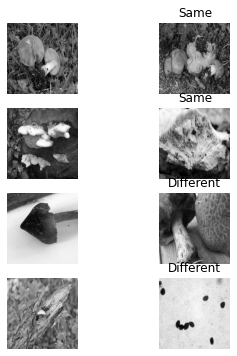

In [12]:
NUMS=4
plt.figure(figsize=(5,NUMS+2));
ii=1
for sample_x,sample_y in zip(source_x[:NUMS],source_y[:NUMS]):
    for takes in sample_x:
        plt.subplot(NUMS,WAYS,ii);plt.imshow(takes[...,0],"gray");plt.axis("off")
        
        ii+=1
    rslt="Same" if sample_y[0] else "Different"
    plt.title(rslt)

# 建立模型
Base model的話範例使用兩層Convolution做為主要network，選ReLu activation且每層中有max pooling和drop out。output前使用兩層MLP化為一個50維向量。

In [15]:
def build_base_network(input_shape):
    seq = Sequential()
    
    nb_filter = [128,128]
    kernel_size = 3
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                           padding="valid",activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, padding="valid",activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

'''計算latent距離'''
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
'''給Lambda layer用的'''
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
'''計算距離，可自訂prediction是要多小才算兩者同類'''
def accu(labels,predictions):
    return K.mean((labels==1)==(predictions<0.5))

接著引導兩個不同影像分別輸進base_network，輸出feat_vecs_a、feat_vecs_b再計算euclidean distance。
Model 使用RMSprop做 optimization。

In [16]:
'''比一般Model input要多一個rank, 區分一次要比較的每一張照片'''
input_dim = (1+QUERIES,W,H,CH)
imgs = Input(shape=input_dim)
base_network = build_base_network(input_dim[1:])

'''算好support latent'''
support_vec=base_network(imgs[:,0,...])
pred=[]
for qq in range(QUERIES):
    '''算query latent'''
    query_vec=base_network(imgs[:,1+qq,...])
    '''算距離'''
    pred.append(Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([support_vec,query_vec]))
distance=tf.concat(pred,axis=-1)

model = Model(inputs=imgs, outputs=distance)

# 模型訓練
訓練使用10 epoch、batch size為16個pairs，並指定loss function為contrastive_loss。
在訓練時再使用validation split驗證loss是否下降，或者只是over fitting。

In [17]:
lr=0.001
'''同類的時候套用左邊的式子，不同類時套用右邊的式子'''
def contrastive_loss(isgenuine, y_pred):
    margin = 1
    return K.mean(isgenuine * K.square(y_pred) + (1 - isgenuine) * K.square(K.maximum(margin - y_pred, 0)))
'''套用RMSProp optimizer，要的話也可以試Adam'''
rms = RMSprop(learning_rate=lr)

model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accu])

In [18]:
EPOCHS=400
'''開一些callbacks紀錄、調整lr、自動結束訓練'''
reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=1e-8, verbose=1)
tensorboard = cb.TensorBoard(log_dir="tf_siamese_logs")
earlystop=cb.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True, verbose=1)

# %%time
try:
    '''用同個generator來validate也還好，因為每次都是不同task'''
    model.fit(data_source, epochs=EPOCHS, verbose=1,workers=4,callbacks=[reduce_lr,earlystop, tensorboard], validation_data=data_source)
except KeyboardInterrupt:
    print("KeyboardInterrupt")

Epoch 1/400
      1/Unknown - 0s 0s/step - loss: 0.3362 - accu: 0.5156WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
     93/Unknown - 50s 541ms/step - loss: 0.2911 - accu: 0.5467WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0156s). Check your callbacks.
94/94 [==============================] - 52s 555ms/step - loss: 0.2912 - accu: 0.5422 - val_loss: 0.2242 - val_accu: 0.6130
Epoch 2/400
94/94 [==============================] - 6s 63ms/step - loss: 0.2360 - accu: 0.6012 - val_loss: 0.2380 - val_accu: 0.6544
Epoch 3/400
94/94 [==============================] - 6s 63ms/step - loss: 0.1884 - accu: 0.7332 - val_loss: 0.1565 - val_accu: 0.7716
E

Epoch 57/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0044 - accu: 0.9978 - val_loss: 9.0210e-04 - val_accu: 1.0000
Epoch 58/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0036 - accu: 0.9973 - val_loss: 8.1201e-04 - val_accu: 1.0000
Epoch 59/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0033 - accu: 0.9992 - val_loss: 7.2939e-04 - val_accu: 1.0000
Epoch 60/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9990 - val_loss: 7.0577e-04 - val_accu: 1.0000
Epoch 61/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0033 - accu: 0.9990 - val_loss: 7.1723e-04 - val_accu: 1.0000
Epoch 62/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0030 - accu: 0.9988 - val_loss: 7.0645e-04 - val_accu: 1.0000
Epoch 63/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0031 - accu: 0.9985 - val_loss: 6.6652e-04 - val_accu: 1.0000
Epoch 64/400
93/94 [=======

94/94 [==============================] - 6s 64ms/step - loss: 0.0032 - accu: 0.9987 - val_loss: 6.5417e-04 - val_accu: 1.0000
Epoch 111/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0025 - accu: 0.9992 - val_loss: 6.5416e-04 - val_accu: 1.0000
Epoch 112/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9988 - val_loss: 6.5416e-04 - val_accu: 1.0000
Epoch 113/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9990 - val_loss: 6.5416e-04 - val_accu: 1.0000
Epoch 114/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0026 - accu: 0.9995 - val_loss: 6.5415e-04 - val_accu: 1.0000
Epoch 115/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0032 - accu: 0.9982 - val_loss: 6.5414e-04 - val_accu: 1.0000
Epoch 116/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0032 - accu: 0.9987 - val_loss: 6.5414e-04 - val_accu: 1.0000
Epoch 117/400
94/94 [=============

94/94 [==============================] - 6s 63ms/step - loss: 0.0032 - accu: 0.9978 - val_loss: 6.5385e-04 - val_accu: 1.0000
Epoch 169/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0035 - accu: 0.9982 - val_loss: 6.5384e-04 - val_accu: 1.0000
Epoch 170/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0030 - accu: 0.9988 - val_loss: 6.5384e-04 - val_accu: 1.0000
Epoch 171/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9988 - val_loss: 6.5384e-04 - val_accu: 1.0000
Epoch 172/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9987 - val_loss: 6.5383e-04 - val_accu: 1.0000
Epoch 173/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0027 - accu: 0.9992 - val_loss: 6.5382e-04 - val_accu: 1.0000
Epoch 174/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9985 - val_loss: 6.5382e-04 - val_accu: 1.0000
Epoch 175/400
94/94 [=============

94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9988 - val_loss: 6.5357e-04 - val_accu: 1.0000
Epoch 227/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0031 - accu: 0.9982 - val_loss: 6.5357e-04 - val_accu: 1.0000
Epoch 228/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0032 - accu: 0.9985 - val_loss: 6.5357e-04 - val_accu: 1.0000
Epoch 229/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0030 - accu: 0.9982 - val_loss: 6.5356e-04 - val_accu: 1.0000
Epoch 230/400
94/94 [==============================] - 6s 64ms/step - loss: 0.0030 - accu: 0.9985 - val_loss: 6.5356e-04 - val_accu: 1.0000
Epoch 231/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0030 - accu: 0.9983 - val_loss: 6.5356e-04 - val_accu: 1.0000
Epoch 232/400
94/94 [==============================] - 6s 64ms/step - loss: 0.0030 - accu: 0.9983 - val_loss: 6.5355e-04 - val_accu: 1.0000
Epoch 233/400
94/94 [=============

94/94 [==============================] - 6s 63ms/step - loss: 0.0028 - accu: 0.9992 - val_loss: 6.5327e-04 - val_accu: 1.0000
Epoch 285/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0026 - accu: 0.9997 - val_loss: 6.5327e-04 - val_accu: 1.0000
Epoch 286/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0033 - accu: 0.9982 - val_loss: 6.5327e-04 - val_accu: 1.0000
Epoch 287/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0030 - accu: 0.9988 - val_loss: 6.5327e-04 - val_accu: 1.0000
Epoch 288/400
94/94 [==============================] - 6s 64ms/step - loss: 0.0027 - accu: 0.9992 - val_loss: 6.5326e-04 - val_accu: 1.0000
Epoch 289/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9987 - val_loss: 6.5326e-04 - val_accu: 1.0000
Epoch 290/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0023 - accu: 0.9993 - val_loss: 6.5325e-04 - val_accu: 1.0000
Epoch 291/400
94/94 [=============

94/94 [==============================] - 6s 63ms/step - loss: 0.0028 - accu: 0.9985 - val_loss: 6.5301e-04 - val_accu: 1.0000
Epoch 343/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0034 - accu: 0.9982 - val_loss: 6.5301e-04 - val_accu: 1.0000
Epoch 344/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0027 - accu: 0.9988 - val_loss: 6.5300e-04 - val_accu: 1.0000
Epoch 345/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0029 - accu: 0.9985 - val_loss: 6.5299e-04 - val_accu: 1.0000
Epoch 346/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0028 - accu: 0.9988 - val_loss: 6.5299e-04 - val_accu: 1.0000
Epoch 347/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0027 - accu: 0.9988 - val_loss: 6.5298e-04 - val_accu: 1.0000
Epoch 348/400
94/94 [==============================] - 6s 63ms/step - loss: 0.0027 - accu: 0.9992 - val_loss: 6.5298e-04 - val_accu: 1.0000
Epoch 349/400
94/94 [=============

94/94 [==============================] - 6s 63ms/step - loss: 0.0032 - accu: 0.9980 - val_loss: 6.5274e-04 - val_accu: 1.0000


In [20]:
model.save('my_model.h5')

# 預測結果
最後使用test data看accuracy，為distance取一個區間(e.g. 0.1)做為評判是否為同個類別的依據。

In [21]:
model.evaluate(data_target)

24/24 [==============================] - 14s 569ms/step - loss: 0.4583 - accu: 0.5645


[0.45829710364341736, 0.564453125]

# Run Kaggle test.csv

In [46]:
W,H,CH = 227,227,1

def load_testimg(path, width = W, hight=H):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.resize(img, (227,227))
    img = img.astype(np.float32)/255.
    
    
    img=np.expand_dims(cv2.resize(img, (W,H)),-1)
    
    return img-0.5


In [51]:
import pandas as pd
dt_test = pd.read_csv('test2.csv')

In [52]:
dt_test['surpport_0']

filename                      support_0  \
0              TS2013PIC17437389.JPG      10000_Abortiporus_biennis   
1              TS2010PIC72338205.JPG    10994_Basidioradulum_radula   
2        TS2016-9169441_H1qNFt0u.JPG   11086_Xerocomellus_pruinatus   
3       MC2017-9207438_B1nMv9EFW.JPG  11202_Buglossoporus_quercinus   
4      MAV2017-9203941_HkwZOvmuZ.JPG  11384_Ceratiomyxa_fruticulosa   
...                              ...                            ...   
2195    MC2017-9216120_B1rV9k4oW.JPG        21155_Tricholoma_ustale   
2196  EAT2017-9205185_BklapgTOOW.JPG        21155_Tricholoma_ustale   
2197          BWP2012PIC41205195.JPG        14849_Gliophorus_laetus   
2198          TRL2015PIC35525891.JPG        14863_Hygrocybe_punicea   
2199  TBE2017-9227098_rkfuS2R1pb.JPG        21155_Tricholoma_ustale   

                            support_1                      support_2  
0            15888_Lactarius_pallidus      10065_Agaricus_campestris  
1            15888_Lactarius_pallidus  11085_Xerocomellus_porosporus  
2         11095_Hortiboletus_rubellus       15888_Lactarius_pallidus  
3              11234_Calocera_viscosa       15888_Lactarius_pallidus  
4            15888_Lactarius_pallidus    11573_Chalciporus_piperatus  
...                               ...                            ...  
2195       14667_Hericium_coralloides    14778_Hydnellum_concrescens  
2196           14799_Hydnum_rufescens    14815_Hygrocybe_acutoconica  
2197         14845_Hygrocybe_insipida        21155_Tricholoma_ustale  
2198          21155_Tricholoma_ustale   14859_Cuphophyllus_pratensis  
2199  14886_Hygrophoropsis_aurantiaca         14866_Hygrocybe_reidii  

[2200 rows x 4 columns]

In [72]:
cols = ['support_0','support_1','support_2']
result = []
for idx in dt_test.index:
    test_img = load_testimg('..\\target_q\\' + dt_test.iloc[idx]['filename'])
    
    distance = 100
    label = -1
    
    for c in cols:
        query_path = '..\\target_s\\' + dt_test.iloc[idx][c]
        query_img_list = [query_path + '\\' + t for t in os.listdir(query_path)]
        for q in query_img_list:
            query_img = load_testimg(q)
            img = np.array([[test_img,query_img]])
            d = float(model.predict(img))
            if (d < distance):
                distance = d
                label = c[-1]
    
    result.append([dt_test.iloc[idx]['filename'],label])
        
    

In [74]:
len(result)

2200

In [76]:
df = pd.DataFrame(result,columns=['filename','ans'])
df.to_csv('test0819.csv',index=False)